In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import multiprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
import zipfile
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

dataset_path = "/content/drive/MyDrive/ND/trashnet.zip"
unzip_dir = "/content/drive/MyDrive/ND/"

#Unzipping the dataset
# with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
#     zip_ref.extractall(unzip_dir)

In [ ]:
#Verifying that the folders have been extracted
os.listdir(unzip_dir+'/dataset-resized')

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [ ]:
#Updating unzipped dataset directory path
unzip_dir =  unzip_dir +'/dataset-resized'

In [ ]:
import os
import random
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm  # For progress tracking

#Defining augmentations
augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),  #For flipping the image horizontally
    transforms.RandomRotation(20)  #For rotating the image randomly by ±20 degrees
])

#Defining image format for saving
IMAGE_FORMAT = "JPEG"

#Updating dataset path
dataset_path = "/content/drive/MyDrive/ND/dataset-resized"

#Getting class folders (cardboard, glass, plastic, ...)
classes = os.listdir(dataset_path)

In [ ]:
classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [ ]:
#Defining transforms
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  #Randomly flipping the images horizontally
    transforms.RandomRotation(20),      #Randomly rotating the images by up to 20 degrees
    transforms.ToTensor(),              #Converting the image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  #Normalizing with ImageNet values
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  #Same normalization for validation
])


In [ ]:
# #Loading full dataset (without transformation)
# full_dataset = datasets.ImageFolder(root=os.path.join(unzip_dir))

# #Splitting dataset: 80% train, 10% validation, 10% test
# total_size = len(full_dataset)
# train_size = int(0.8 * total_size)
# val_size = int(0.1 * total_size)
# test_size = total_size - train_size - val_size  #Ensuring no leftover samples

# train_indices, val_indices, test_indices = random_split(full_dataset, [train_size, val_size, test_size])

# #Creating separate datasets with correct transforms
# train_dataset = datasets.ImageFolder(root=os.path.join(unzip_dir), transform=transform_train)
# val_dataset = datasets.ImageFolder(root=os.path.join(unzip_dir), transform=transform_val)
# test_dataset = datasets.ImageFolder(root=os.path.join(unzip_dir), transform=transform_val)

# #Applying indexing manually to get the right split
# train_dataset.samples = [train_dataset.samples[i] for i in train_indices.indices]
# val_dataset.samples = [val_dataset.samples[i] for i in val_indices.indices]
# test_dataset.samples = [test_dataset.samples[i] for i in test_indices.indices]

# #Creating DataLoaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# #Checking one batch
# for images, labels in train_loader:
#     print(images.shape, labels.shape)  # Expected: (batch_size, 3, H, W) and (batch_size,)
#     break


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

#Defining the model
model = models.resnet18(pretrained=True)  #Using pretrained ResNet-18

#Modifying the final layer to match the number of classes (6 classes)
model.fc = nn.Linear(model.fc.in_features, 6)

#Moving the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 196MB/s]


cuda


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import os
from tqdm import tqdm  #Importing tqdm for live progress

#Training and evaluation functions
def train(model, train_loader, optimizer, criterion, device):
    model.train()  #Setting model to training mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    progress_bar = tqdm(train_loader, desc="Training", leave=False)  #Live progress bar
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  #Zero out gradients
        outputs = model(images)  #Forward pass
        loss = criterion(outputs, labels)  #Calculate loss
        loss.backward()  #Backpropagation
        optimizer.step()  #Update weights

        running_loss += loss.item()

        #Calculating accuracy
        _, preds = torch.max(outputs, 1)
        correct_preds += torch.sum(preds == labels).item()
        total_preds += labels.size(0)

        #Updating tqdm progress bar with loss & accuracy
        progress_bar.set_postfix(loss=running_loss / (total_preds / images.size(0)),
                                 acc=correct_preds / total_preds)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_preds / total_preds
    return avg_loss, accuracy

def evaluate(model, val_loader, criterion, device):
    model.eval()  #Setting model to evaluation mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    progress_bar = tqdm(val_loader, desc="Validating", leave=False)  #Live progress bar
    with torch.no_grad():
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            #Calculating accuracy
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels).item()
            total_preds += labels.size(0)

            #Updating tqdm progress bar with loss & accuracy
            progress_bar.set_postfix(loss=running_loss / (total_preds / images.size(0)),
                                     acc=correct_preds / total_preds)

    avg_loss = running_loss / len(val_loader)
    accuracy = correct_preds / total_preds
    return avg_loss, accuracy


In [ ]:
# print("Unique labels in dataset:", set(label for _, label in train_loader.dataset))

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
from PIL import Image, UnidentifiedImageError
import os

class CustomImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        try:
            path, label = self.imgs[index]
            image = Image.open(path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            return image, label  #Only returning image and label
        except (UnidentifiedImageError, OSError) as e:
            print(f"Skipping corrupted image: {self.imgs[index][0]}")
            return self.__getitem__((index + 1) % len(self))

#Loading dataset with modified class
dataset = CustomImageFolder(root=os.path.join(dataset_path), transform=ToTensor())

#Splitting dataset
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

#Applying transformations
train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_val
test_dataset.dataset.transform = transform_val

#Creating DataLoaders (yield only images and labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#Checking one batch, expecting 2 values
for images, labels in train_loader:
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Unique labels: {torch.unique(labels)}")
    break

Batch shape: torch.Size([32, 3, 384, 512])
Labels shape: torch.Size([32])
Unique labels: tensor([0, 1, 2, 3, 4])


In [ ]:
print(dataset.class_to_idx)  #Showing how class names map to indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [ ]:
print(f"Unique labels in batch: {labels.unique()}")

Unique labels in batch: tensor([0, 1, 2, 3, 4])


In [ ]:
#Testing with 1 epoch initially
epochs = 1
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

#Creating a directory to save models
save_dir = "/content/drive/MyDrive/ND/saved_models_final"
os.makedirs(save_dir, exist_ok=True)

best_val_accuracy = 0.0
best_model_path = os.path.join(save_dir, "best_model.pth")
final_model_path = os.path.join(save_dir, "final_model.pth")

#Training the model
for epoch in range(epochs):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy*100:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy*100:.2f}%")

    #Saving the best model based on validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Best model saved at Epoch {epoch+1} with Validation Accuracy: {val_accuracy*100:.2f}%")

#Saving the final model at the end of training
torch.save(model.state_dict(), final_model_path)
print(f"📌 Final model saved at {final_model_path}")

In [ ]:
from PIL import Image
import torch
import torch.nn.functional as F

def classify_image(image_path, model, transform, class_names, device='cuda'):
    """
    Classifying a single image using the trained model

    Args:
        image_path: Path to the image file
        model: Trained PyTorch model
        transform: Image transformations
        class_names: List of class names
        device: Device to run inference on
    """
    #Loading and preprocessing the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    #Setting model to evaluation mode
    model.eval()

    #Making prediction
    with torch.no_grad():
        output = model(image)
        probabilities = F.softmax(output, dim=1)
        confidence, predicted_idx = torch.max(probabilities, 1)

    #Converting to human-readable results
    predicted_class = class_names[predicted_idx.item()]
    confidence_percent = confidence.item() * 100

    return {
        'class': predicted_class,
        'confidence': f"{confidence_percent:.2f}%",
        'all_probabilities': {name: f"{prob*100:.2f}%"
                             for name, prob in zip(class_names, probabilities.squeeze().cpu().numpy())}
    }

In [ ]:
#Loading the best model
model.load_state_dict(torch.load(best_model_path))
model = model.to(device)

#Defining inference transform (matching the validation transform)
inference_transform = transforms.Compose([
    transforms.Resize((384, 512)),  #Matching the training size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#Getting class names
class_names = dataset.classes  #['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [ ]:
image_path = "/content/drive/MyDrive/ND/test5_img.png"

result = classify_image(
    image_path=image_path,
    model=model,
    transform=inference_transform,
    class_names=class_names,
    device=device
)

print(f"Predicted class: {result['class']}")
print(f"Confidence: {result['confidence']}")
print("\nAll class probabilities:")
for cls, prob in result['all_probabilities'].items():
    print(f"{cls}: {prob}")

Predicted class: metal
Confidence: 61.06%

All class probabilities:
cardboard: 0.09%
glass: 0.00%
metal: 61.06%
paper: 5.95%
plastic: 0.39%
trash: 32.50%


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


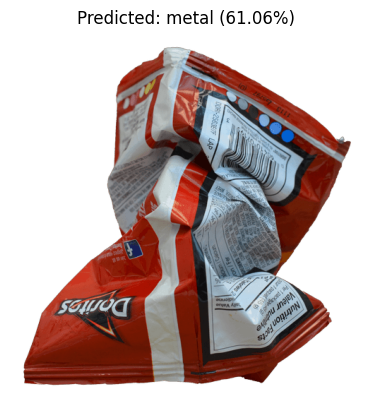

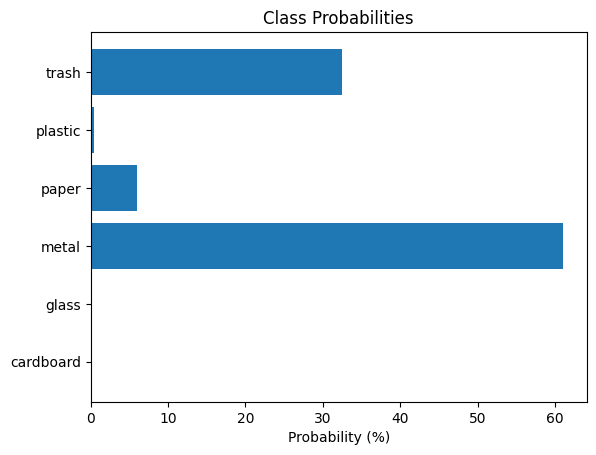

In [ ]:
import matplotlib.pyplot as plt

def show_classification(image_path, result):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f"Predicted: {result['class']} ({result['confidence']})")
    plt.axis('off')
    plt.show()

    #Plotting probabilities
    plt.barh(result['all_probabilities'].keys(),
             [float(p.strip('%')) for p in result['all_probabilities'].values()])
    plt.xlabel('Probability (%)')
    plt.title('Class Probabilities')
    plt.show()

show_classification(image_path, result)

Training:   0%|          | 0/323 [00:00<?, ?it/s]

Skipping corrupted image: /content/drive/MyDrive/ND/dataset-resized/glass/glass245_aug1_aug2.jpeg
Skipping corrupted image: /content/drive/MyDrive/ND/dataset-resized/cardboard/cardboard1.jpg
Skipping corrupted image: /content/drive/MyDrive/ND/dataset-resized/cardboard/cardboard367.jpg
Epoch 1/5
Train Loss: 0.0141, Train Accuracy: 99.46%
Validation Loss: 0.0573, Validation Accuracy: 98.37%
✅ Best model saved at Epoch 1 with Validation Accuracy: 98.37%


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Skipping corrupted image: /content/drive/MyDrive/ND/dataset-resized/glass/glass245_aug1_aug2.jpeg
Skipping corrupted image: /content/drive/MyDrive/ND/dataset-resized/cardboard/cardboard1.jpg
Skipping corrupted image: /content/drive/MyDrive/ND/dataset-resized/cardboard/cardboard367.jpg
Epoch 2/5
Train Loss: 0.0286, Train Accuracy: 99.68%
Validation Loss: 0.0382, Validation Accuracy: 98.84%
✅ Best model saved at Epoch 2 with Validation Accuracy: 98.84%


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Skipping corrupted image: /content/drive/MyDrive/ND/dataset-resized/cardboard/cardboard1.jpg
Skipping corrupted image: /content/drive/MyDrive/ND/dataset-resized/glass/glass245_aug1_aug2.jpeg
Skipping corrupted image: /content/drive/MyDrive/ND/dataset-resized/cardboard/cardboard367.jpg
Epoch 3/5
Train Loss: 0.0212, Train Accuracy: 99.31%
Validation Loss: 0.0306, Validation Accuracy: 99.07%
✅ Best model saved at Epoch 3 with Validation Accuracy: 99.07%


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Skipping corrupted image: /content/drive/MyDrive/ND/dataset-resized/glass/glass245_aug1_aug2.jpeg
Skipping corrupted image: /content/drive/MyDrive/ND/dataset-resized/cardboard/cardboard367.jpg
Skipping corrupted image: /content/drive/MyDrive/ND/dataset-resized/cardboard/cardboard1.jpg
Epoch 4/5
Train Loss: 0.0022, Train Accuracy: 99.92%
Validation Loss: 0.0277, Validation Accuracy: 99.07%


Training:   0%|          | 0/323 [00:00<?, ?it/s]

Skipping corrupted image: /content/drive/MyDrive/ND/dataset-resized/cardboard/cardboard1.jpg
Skipping corrupted image: /content/drive/MyDrive/ND/dataset-resized/glass/glass245_aug1_aug2.jpeg
Skipping corrupted image: /content/drive/MyDrive/ND/dataset-resized/cardboard/cardboard367.jpg
Epoch 5/5
Train Loss: 0.0031, Train Accuracy: 99.91%
Validation Loss: 0.0230, Validation Accuracy: 99.30%
✅ Best model saved at Epoch 5 with Validation Accuracy: 99.30%
📌 Final model saved at /content/drive/MyDrive/ND/saved_models_final/final_model.pth


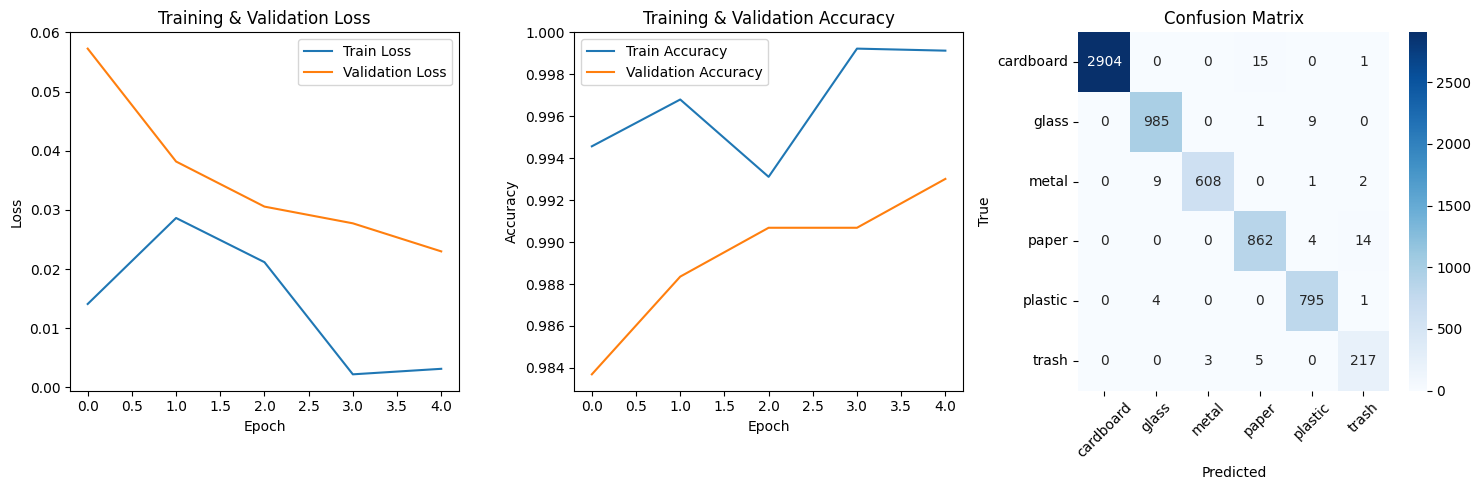

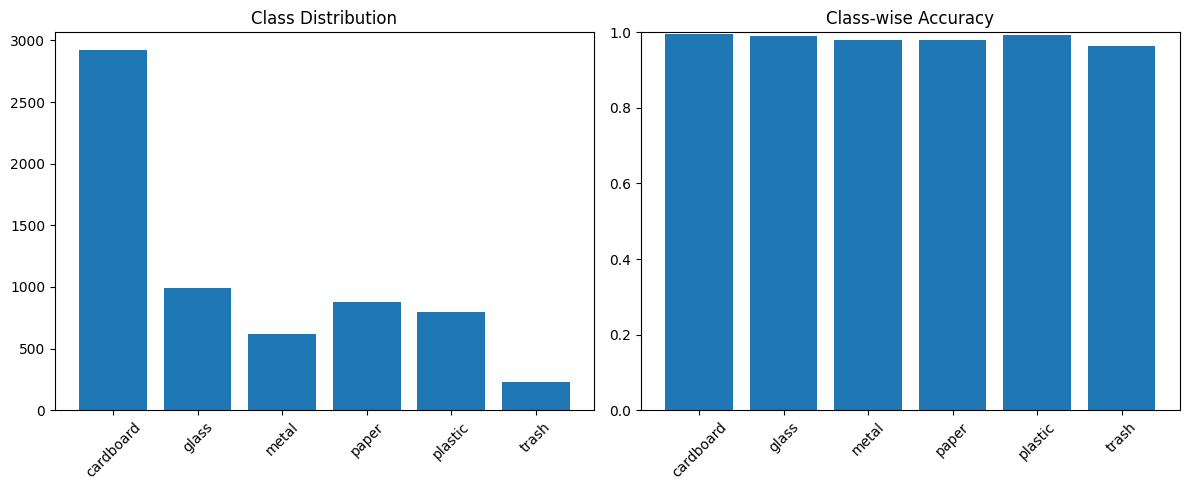

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

#Increasing epochs
epochs = 5
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

#Creating a directory to save models
save_dir = "/content/drive/MyDrive/ND/saved_models_final"
os.makedirs(save_dir, exist_ok=True)

best_val_accuracy = 0.0
best_model_path = os.path.join(save_dir, "best_model.pth")
final_model_path = os.path.join(save_dir, "final_model.pth")

#Initializing lists for metrics storage
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
all_preds = []
all_labels = []

#Training the model
for epoch in range(epochs):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_accuracy, val_preds, val_labels = evaluate(model, val_loader, criterion, device)

    #Storing metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    all_preds.extend(val_preds)
    all_labels.extend(val_labels)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy*100:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy*100:.2f}%")

    #Saving the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Best model saved at Epoch {epoch+1} with Validation Accuracy: {val_accuracy*100:.2f}%")

#Saving the final model
torch.save(model.state_dict(), final_model_path)
print(f"📌 Final model saved at {final_model_path}")

#===== Visualization Section =====
plt.figure(figsize=(15, 5))

#Training and Validation Curves
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#Confusion Matrix
plt.subplot(1, 3, 3)
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

#Class Distribution and Accuracy
class_counts = {cls: 0 for cls in dataset.classes}
for label in all_labels:
    class_counts[dataset.classes[label]] += 1

class_acc = {}
for cls in dataset.classes:
    cls_idx = dataset.class_to_idx[cls]
    mask = np.array(all_labels) == cls_idx
    if sum(mask) > 0:
        class_acc[cls] = np.mean(np.array(all_preds)[mask] == cls_idx)
    else:
        class_acc[cls] = 0

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Class Distribution')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(class_acc.keys(), class_acc.values())
plt.title('Class-wise Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import precision_score, f1_score
import numpy as np

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    return precision, f1

# Load Model 1 (from Code 1)
model1 = models.resnet18(pretrained=False)
model1.fc = nn.Linear(model1.fc.in_features, 6)
model1.load_state_dict(torch.load("/content/drive/MyDrive/ND/saved_models_final/best_model.pth"))
model1 = model1.to(device)

# Evaluate
precision1, f1_1 = evaluate_model(model1, test_loader, device)
print(f"Model 1 (Code 1) Metrics:")
print(f"Precision: {precision1:.4f}")
print(f"F1 Score: {f1_1:.4f}")

Model 1 (Code 1) Metrics:
Precision: 0.9940
F1 Score: 0.9938


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Image: test_img.jpeg
cardboard: 0.0%
glass: 100.0%
metal: 0.0%
paper: 0.0%
plastic: 0.0%
trash: 0.0%

Image: test2_img.jpg
cardboard: 4.9%
glass: 0.0%
metal: 0.0%
paper: 95.1%
plastic: 0.0%
trash: 0.0%

Image: test3_img.jpeg
cardboard: 0.2%
glass: 0.0%
metal: 0.0%
paper: 99.8%
plastic: 0.0%
trash: 0.0%

Image: test4_img.jpeg
cardboard: 0.0%
glass: 0.0%
metal: 0.0%
paper: 100.0%
plastic: 0.0%
trash: 0.0%

Image: test5_img.png
cardboard: 0.0%
glass: 0.0%
metal: 0.0%
paper: 100.0%
plastic: 0.0%
trash: 0.0%


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


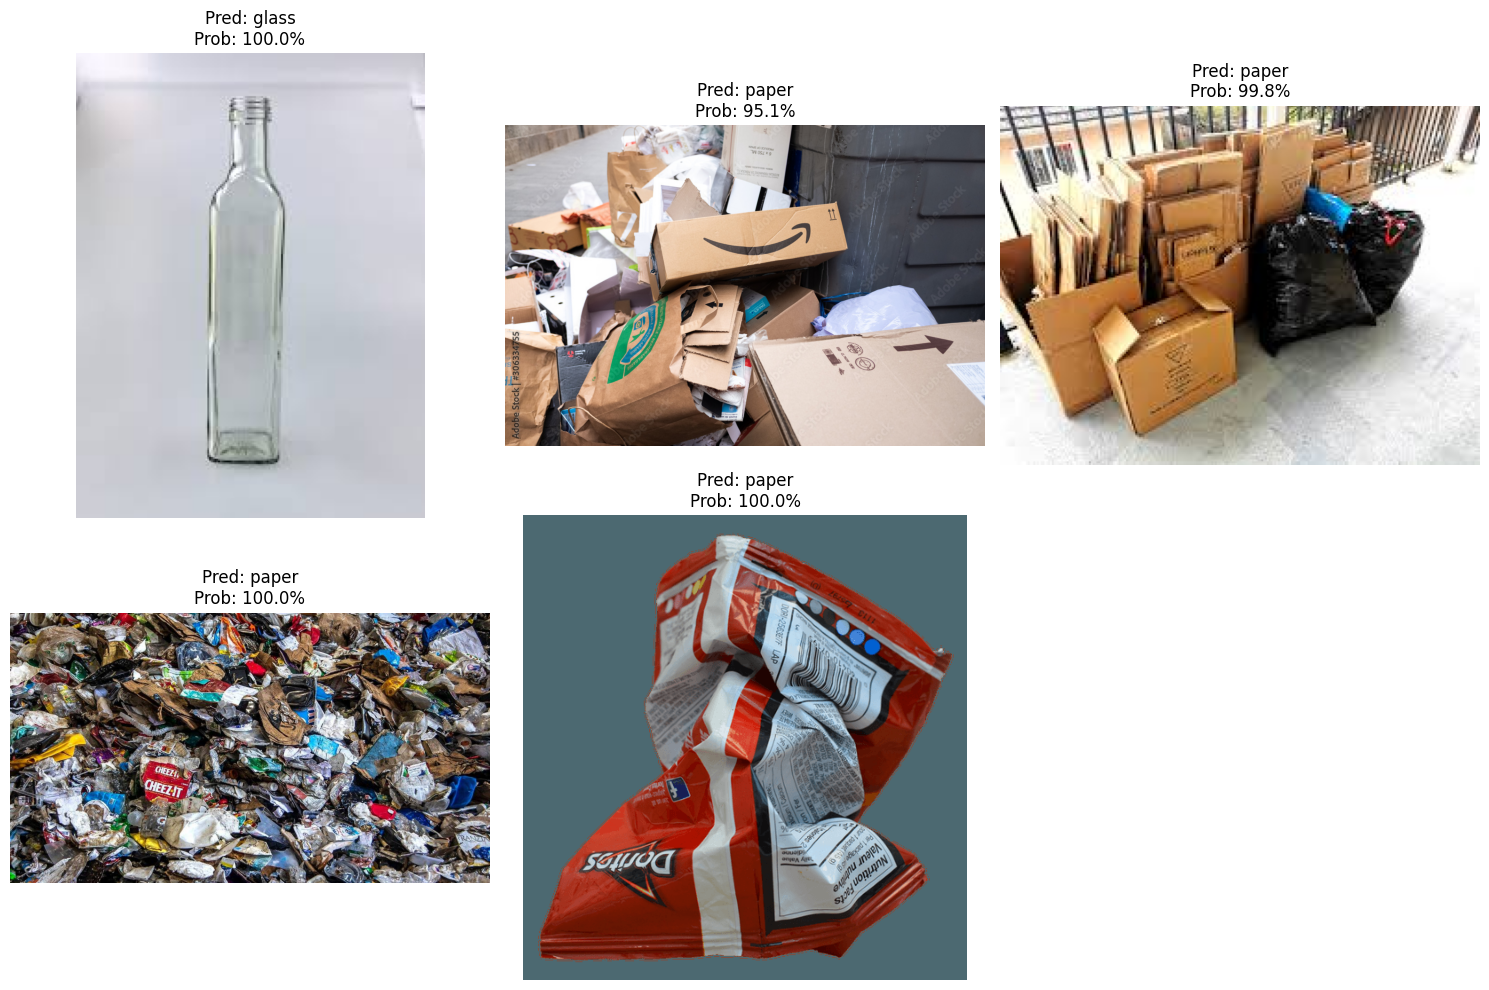

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

#Loading the saved model
model_path = "/content/drive/MyDrive/ND/saved_models_final/best_model.pth"
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 6)  #6 classes
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

#Defining test transforms (same as validation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#Getting class names from dataset
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

#Testing directory
test_dir = "/content/drive/MyDrive/ND/test_images"

#Processing each test image
plt.figure(figsize=(15, 10))
for i, img_file in enumerate(os.listdir(test_dir)):
    img_path = os.path.join(test_dir, img_file)

    try:
        #Loading and preprocessing image
        img = Image.open(img_path).convert('RGB')
        img_tensor = test_transform(img).unsqueeze(0).to(device)

        #Making prediction
        with torch.no_grad():
            outputs = model(img_tensor)
            _, pred = torch.max(outputs, 1)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)[0] * 100

        #Displaying results
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f"Pred: {class_names[pred.item()]}\n"
                 f"Prob: {probabilities[pred.item()]:.1f}%")
        plt.axis('off')

        #Printing detailed probabilities
        print(f"\nImage: {img_file}")
        for idx, cls in enumerate(class_names):
            print(f"{cls}: {probabilities[idx]:.1f}%")

    except Exception as e:
        print(f"Skipping {img_file} due to error: {e}")

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#Calculating class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_dataset.dataset.targets),
    y=train_dataset.dataset.targets
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

#Modifying your loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
for cls, weight in zip(dataset.classes, class_weights.cpu().numpy()):
    print(f"{cls}: {weight:.2f}")

cardboard: 0.37
glass: 1.00
metal: 1.75
paper: 1.20
plastic: 1.48
trash: 5.22


Training:   0%|          | 0/323 [00:00<?, ?batch/s]

Skipping corrupted image: /content/drive/MyDrive/ND/dataset-resized/cardboard/cardboard367.jpg
Skipping corrupted image: /content/drive/MyDrive/ND/dataset-resized/glass/glass245_aug1_aug2.jpeg
Skipping corrupted image: /content/drive/MyDrive/ND/dataset-resized/cardboard/cardboard1.jpg


Validating:   0%|          | 0/41 [00:00<?, ?batch/s]


Epoch 1/5 Summary:
Train Loss: 0.0087 | Acc: 99.81%
Val Loss: 0.0493 | Acc: 99.22%

Class-wise Accuracy:
  trash       : 97.78%
  paper       : 98.30%
  glass       : 98.49%
  plastic     : 98.75%
  metal       : 99.19%
  cardboard   : 100.00%

🏆 New best model saved (Val Acc: 99.22%)


Training:   0%|          | 0/323 [00:00<?, ?batch/s]

Skipping corrupted image: /content/drive/MyDrive/ND/dataset-resized/glass/glass245_aug1_aug2.jpeg
Skipping corrupted image: /content/drive/MyDrive/ND/dataset-resized/cardboard/cardboard367.jpg
Skipping corrupted image: /content/drive/MyDrive/ND/dataset-resized/cardboard/cardboard1.jpg


Validating:   0%|          | 0/41 [00:00<?, ?batch/s]


Epoch 2/5 Summary:
Train Loss: 0.0066 | Acc: 99.89%
Val Loss: 0.0388 | Acc: 99.53%

Class-wise Accuracy:
  trash       : 95.56%
  paper       : 98.86%
  metal       : 99.19%
  glass       : 99.50%
  cardboard   : 100.00%
  plastic     : 100.00%

🏆 New best model saved (Val Acc: 99.53%)


Training:   0%|          | 0/323 [00:00<?, ?batch/s]

Skipping corrupted image: /content/drive/MyDrive/ND/dataset-resized/glass/glass245_aug1_aug2.jpeg
Skipping corrupted image: /content/drive/MyDrive/ND/dataset-resized/cardboard/cardboard1.jpg
Skipping corrupted image: /content/drive/MyDrive/ND/dataset-resized/cardboard/cardboard367.jpg


Validating:   0%|          | 0/41 [00:00<?, ?batch/s]


Epoch 3/5 Summary:
Train Loss: 0.0087 | Acc: 99.74%
Val Loss: 0.0423 | Acc: 99.46%

Class-wise Accuracy:
  trash       : 97.78%
  paper       : 98.30%
  metal       : 99.19%
  plastic     : 99.38%
  glass       : 99.50%
  cardboard   : 100.00%


Training:   0%|          | 0/323 [00:00<?, ?batch/s]

Skipping corrupted image: /content/drive/MyDrive/ND/dataset-resized/glass/glass245_aug1_aug2.jpeg
Skipping corrupted image: /content/drive/MyDrive/ND/dataset-resized/cardboard/cardboard1.jpg
Skipping corrupted image: /content/drive/MyDrive/ND/dataset-resized/cardboard/cardboard367.jpg


Validating:   0%|          | 0/41 [00:00<?, ?batch/s]


Epoch 4/5 Summary:
Train Loss: 0.0018 | Acc: 99.95%
Val Loss: 0.0359 | Acc: 99.53%

Class-wise Accuracy:
  trash       : 93.33%
  metal       : 99.19%
  paper       : 99.43%
  glass       : 99.50%
  cardboard   : 100.00%
  plastic     : 100.00%


Training:   0%|          | 0/323 [00:00<?, ?batch/s]

Skipping corrupted image: /content/drive/MyDrive/ND/dataset-resized/glass/glass245_aug1_aug2.jpeg
Skipping corrupted image: /content/drive/MyDrive/ND/dataset-resized/cardboard/cardboard1.jpg
Skipping corrupted image: /content/drive/MyDrive/ND/dataset-resized/cardboard/cardboard367.jpg


Validating:   0%|          | 0/41 [00:00<?, ?batch/s]


Epoch 5/5 Summary:
Train Loss: 0.0043 | Acc: 99.90%
Val Loss: 0.0464 | Acc: 99.38%

Class-wise Accuracy:
  trash       : 93.33%
  paper       : 98.86%
  metal       : 99.19%
  plastic     : 99.38%
  cardboard   : 99.83%
  glass       : 100.00%


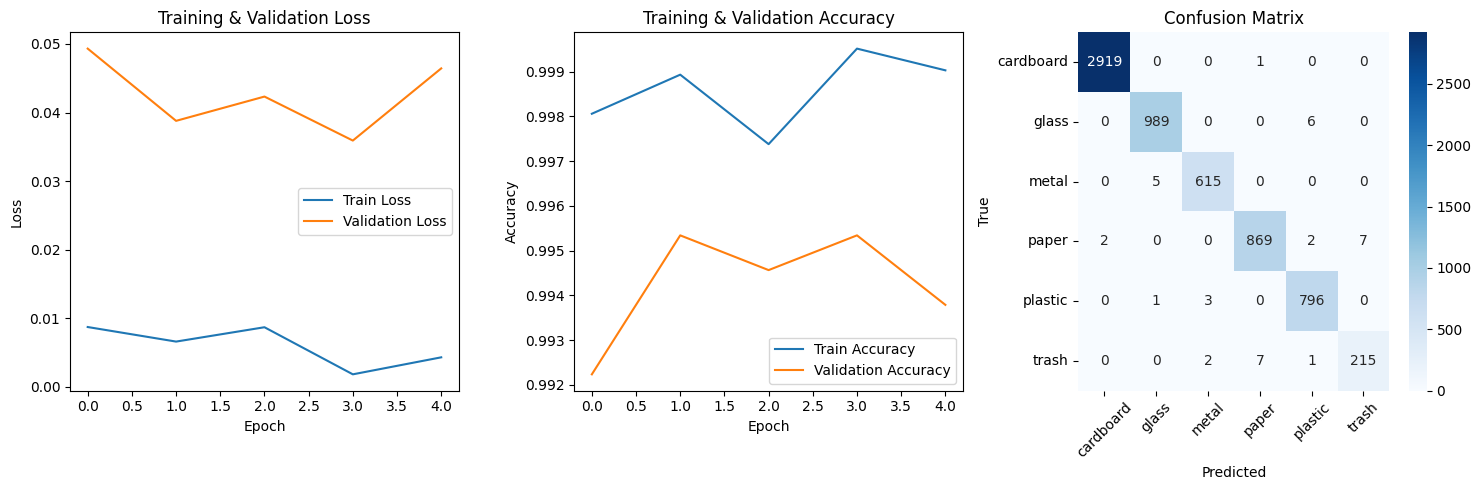

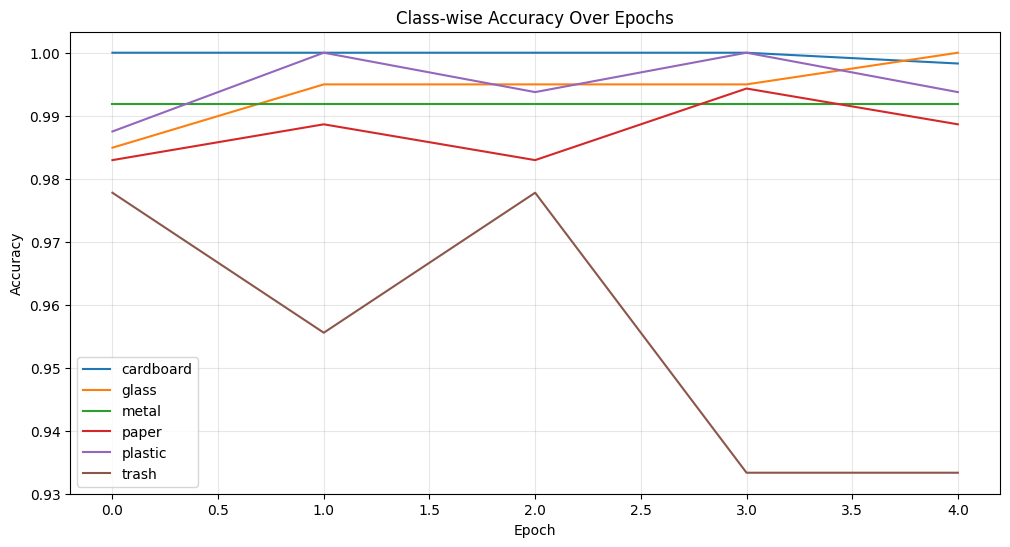

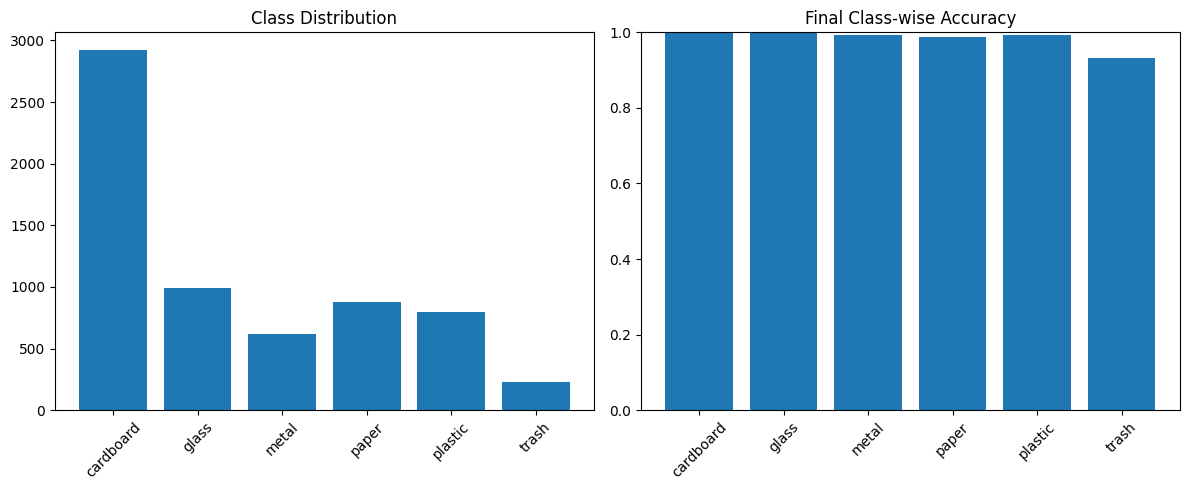

In [ ]:
from tqdm.auto import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

#Enhanced training function with clean progress
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    with tqdm(loader, unit="batch", desc="Training", leave=False) as pbar:
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pbar.set_postfix({
                'loss': f"{total_loss/(pbar.n+1):.4f}",
                'acc': f"{correct/total:.2%}"
            })

    return total_loss/len(loader), correct/total

#Enhanced validation function
def validate_epoch(model, loader, criterion, device, class_names):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    class_stats = {cls: {'correct': 0, 'total': 0} for cls in class_names}

    with tqdm(loader, unit="batch", desc="Validating", leave=False) as pbar:
        with torch.no_grad():
            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                for lbl, pred in zip(labels.cpu(), predicted.cpu()):
                    cls = class_names[lbl.item()]
                    class_stats[cls]['total'] += 1
                    if lbl == pred:
                        class_stats[cls]['correct'] += 1

                pbar.set_postfix({
                    'loss': f"{total_loss/(pbar.n+1):.4f}",
                    'acc': f"{correct/total:.2%}"
                })

    #Calculating class accuracies
    class_acc = {cls: stats['correct']/max(1, stats['total'])
                for cls, stats in class_stats.items()}

    return total_loss/len(loader), correct/total, class_acc, all_preds, all_labels

#Main training loop with clean output
def train_model(model, train_loader, val_loader, class_names, epochs=5):
    # Calculating class weights
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(train_dataset.dataset.targets),
        y=np.array(train_dataset.dataset.targets)
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.00005)

    best_val_acc = 0
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'class_acc': {cls: [] for cls in class_names},
        'all_preds': [], 'all_labels': []
    }

    for epoch in range(epochs):
        #Training phase
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)

        #Validation phase
        val_loss, val_acc, class_acc, val_preds, val_labels = validate_epoch(
            model, val_loader, criterion, device, class_names)

        #Updating history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['all_preds'].extend(val_preds)
        history['all_labels'].extend(val_labels)
        for cls in class_names:
            history['class_acc'][cls].append(class_acc[cls])

        print(f"\nEpoch {epoch+1}/{epochs} Summary:")
        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.2%}")
        print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.2%}")

        print("\nClass-wise Accuracy:")
        for cls, acc in sorted(class_acc.items(), key=lambda x: x[1]):
            print(f"  {cls:<12}: {acc:.2%}")

        #Saving the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"\n🏆 New best model saved (Val Acc: {val_acc:.2%})")

    return history

#Running training
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    class_names=dataset.classes,
    epochs=5
)

#Saving final results
torch.save(model.state_dict(), final_model_path)
torch.save(history, os.path.join(save_dir, 'training_history.pth'))

#===== Visualization Section =====
plt.figure(figsize=(15, 5))

#Training and Validation Curves
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#Confusion Matrix
plt.subplot(1, 3, 3)
cm = confusion_matrix(history['all_labels'], history['all_preds'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

#Class-wise Accuracy Evolution
plt.figure(figsize=(12, 6))
for cls, acc in history['class_acc'].items():
    plt.plot(acc, label=cls)
plt.title('Class-wise Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#Final Class Distribution and Accuracy
final_class_acc = {cls: acc[-1] for cls, acc in history['class_acc'].items()}
class_counts = {cls: 0 for cls in dataset.classes}
for label in history['all_labels']:
    class_counts[dataset.classes[label]] += 1

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Class Distribution')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(final_class_acc.keys(), final_class_acc.values())
plt.title('Final Class-wise Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
def evaluate_model_with_details(model, test_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate overall metrics
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    # Class-wise metrics
    class_precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
    class_f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)

    # Print class-wise results
    print("\nClass-wise Performance:")
    for i, cls in enumerate(class_names):
        print(f"{cls}: Precision = {class_precision[i]:.4f}, F1 = {class_f1[i]:.4f}")

    return precision, f1

# Load Model 2 (from Code 2)
model2 = models.resnet18(pretrained=False)
model2.fc = nn.Linear(model2.fc.in_features, 6)
model2.load_state_dict(torch.load("/content/drive/MyDrive/ND/saved_models_final_with_metrics/best_model.pth"))
model2 = model2.to(device)

# Evaluate
precision2, f1_2 = evaluate_model_with_details(model2, test_loader, device, dataset.classes)
print(f"\nModel 2 (Code 2) Metrics:")
print(f"Precision: {precision2:.4f}")
print(f"F1 Score: {f1_2:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Class-wise Performance:
cardboard: Precision = 1.0000, F1 = 1.0000
glass: Precision = 1.0000, F1 = 1.0000
metal: Precision = 1.0000, F1 = 1.0000
paper: Precision = 1.0000, F1 = 1.0000
plastic: Precision = 1.0000, F1 = 1.0000
trash: Precision = 1.0000, F1 = 1.0000

Model 2 (Code 2) Metrics:
Precision: 1.0000
F1 Score: 1.0000


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Image: test_img.jpeg
Predicted: glass (100.0%)
All class probabilities:
cardboard: 0.0%
glass: 100.0%
metal: 0.0%
paper: 0.0%
plastic: 0.0%
trash: 0.0%

Image: test2_img.jpg
Predicted: paper (98.8%)
All class probabilities:
cardboard: 1.2%
glass: 0.0%
metal: 0.0%
paper: 98.8%
plastic: 0.0%
trash: 0.0%

Image: test3_img.jpeg
Predicted: cardboard (99.5%)
All class probabilities:
cardboard: 99.5%
glass: 0.0%
metal: 0.0%
paper: 0.5%
plastic: 0.0%
trash: 0.0%

Image: test4_img.jpeg
Predicted: paper (72.0%)
All class probabilities:
cardboard: 0.0%
glass: 0.0%
metal: 28.0%
paper: 72.0%
plastic: 0.0%
trash: 0.0%


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Image: test5_img.png
Predicted: trash (98.0%)
All class probabilities:
cardboard: 0.2%
glass: 0.0%
metal: 0.0%
paper: 1.8%
plastic: 0.0%
trash: 98.0%


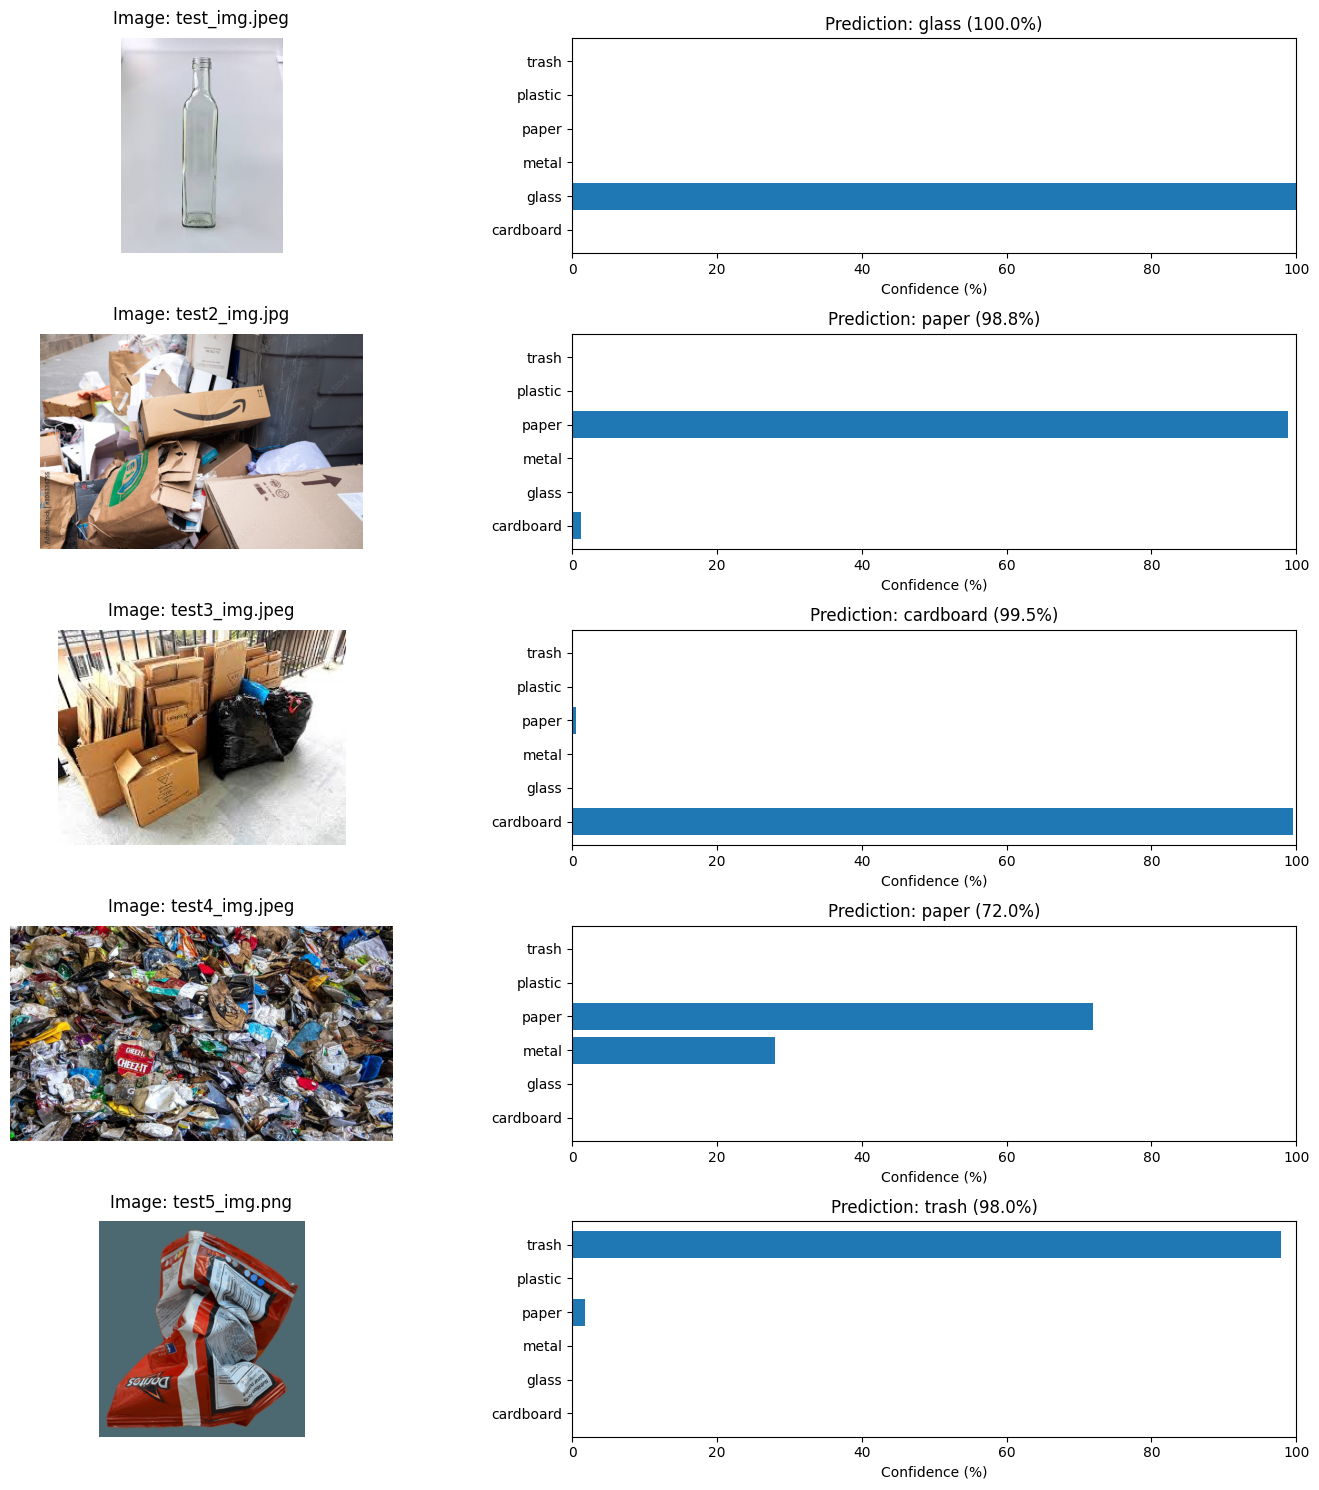

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

#Loading the saved model
model_path = "/content/drive/MyDrive/ND/saved_models_final_with_metrics/best_model.pth"
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 6)  #6 classes
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

#Defining test transforms (same as validation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#Getting class names from dataset
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

#Testing directory
test_dir = "/content/drive/MyDrive/ND/test_images"

#Processing each test image with confidence visualization
plt.figure(figsize=(15, 15))
for i, img_file in enumerate(os.listdir(test_dir)):
    img_path = os.path.join(test_dir, img_file)

    try:
        #Loading and preprocessing image
        img = Image.open(img_path).convert('RGB')
        img_tensor = test_transform(img).unsqueeze(0).to(device)

        #Making prediction
        with torch.no_grad():
            outputs = model(img_tensor)
            _, pred = torch.max(outputs, 1)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)[0] * 100

        #Creating visualization
        plt.subplot(len(os.listdir(test_dir)), 2, i*2+1)
        plt.imshow(img)
        plt.title(f"Image: {img_file}", pad=10)
        plt.axis('off')

        plt.subplot(len(os.listdir(test_dir)), 2, i*2+2)
        y_pos = np.arange(len(class_names))
        plt.barh(y_pos, probabilities.cpu().numpy(), align='center')
        plt.yticks(y_pos, class_names)
        plt.xlabel('Confidence (%)')
        plt.title(f"Prediction: {class_names[pred.item()]} ({probabilities[pred.item()]:.1f}%)")
        plt.xlim(0, 100)

        #Printing detailed results
        print(f"\nImage: {img_file}")
        print(f"Predicted: {class_names[pred.item()]} ({probabilities[pred.item()]:.1f}%)")
        print("All class probabilities:")
        for idx, cls in enumerate(class_names):
            print(f"{cls}: {probabilities[idx]:.1f}%")

    except Exception as e:
        print(f"Skipping {img_file} due to error: {e}")

plt.tight_layout()
plt.show()